In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the preprocessed dataset
df = pd.read_csv("../data/processed_bitcoin_prices.csv", parse_dates=["Date"], index_col="Date")

# Display dataset
df.head()

,Open,High,Low,Close,Volume,Close_Scaled,Prediction
Date,,,,,,,
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465,0.035173,0.069448
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032,0.031686,0.070143
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275,0.037456,0.069421
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095,0.038497,0.068592
2020-01-06,7769.219238,7781.867188,7409.292969,7410.452148,23276261598,0.038497,0.066843


In [6]:
# Function to create sequences of past n_steps days
def create_sequences(data, n_steps=30):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Set the number of past days to use for predictions
n_steps = 30

# Prepare input (X) and target (y)
X, y = create_sequences(df["Close_Scaled"].values, n_steps)

# Split into training (80%) and testing (20%) sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1152, 30, 1)
Testing data shape: (289, 30, 1)


In [7]:
# Define the LSTM model using Input() to avoid warnings
model = Sequential([
    Input(shape=(n_steps, 1)),  # Instead of input_shape in LSTM layer
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0496 - val_loss: 9.6209e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0042 - val_loss: 6.2313e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0036 - val_loss: 7.0555e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0036 - val_loss: 5.2642e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0033 - val_loss: 8.3301e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0030 - val_loss: 3.9462e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0027 - val_loss: 4.6400e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0023 - val_loss: 4.0530e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0024 - val_loss: 4.0015e-04
Epoch 12/50
36/36 ━━━━━━━━━

In [9]:
# Make predictions
predictions = model.predict(X_test)

# Convert predictions back to original scale
predictions_rescaled = np.interp(predictions, (0, 1), (df["Close"].min(), df["Close"].max()))
y_test_rescaled = np.interp(y_test, (0, 1), (df["Close"].min(), df["Close"].max()))

# Calculate error metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
Mean Absolute Error (MAE): 658.39
Mean Squared Error (MSE): 865800.07


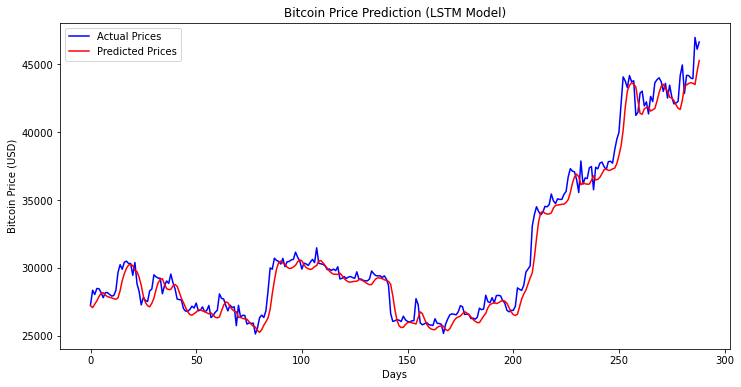

In [10]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(predictions_rescaled, label="Predicted Prices", color="red")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Bitcoin Price (USD)")
plt.title("Bitcoin Price Prediction (LSTM Model)")
plt.show()
